# Candidate Number: 089744

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import warnings
import itertools
import statsmodels.api as sm
warnings.filterwarnings("ignore")

# Decision Tree Regressor

## Data Preprocessing Functions

This step involves converting date column to timestamp, setting date as index, calculating rolling averages, plotting trends, first order differencing

In [27]:
# convert date column to timestamp
def convert_date_col_to_datetime(df, date_col):
    df[date_col] = pd.to_datetime(df[date_col])
    return df

In [28]:
# set date as index
def set_date_as_index(df, date_col):
    df = df.set_index(date_col)
    return df

In [29]:
# calculate rolling average
def calculate_rolling_average(df, col, win):
    df_columns = [col]
    rolling_avg = df[df_columns].rolling(window = win, center = True).mean()
    return rolling_avg

In [30]:
# plot daily, weekly and annual trends
def plot_trends_annual_weekly_daily(daily_df, annual_df, weekly_df, col):
    fig, ax = plt.subplots(figsize = (12,5))

    # plot daily data
    ax.plot(daily_df['Adj Close'], marker='o', markersize=2, color='0.4', linestyle='None', label='Daily')

    # plot 7-day rolling avg data
    ax.plot(weekly_df['Adj Close'], linewidth=2, label='7 day Rolling Mean') 

    # plot annual (365 days) rolling data
    ax.plot(annual_df['Adj Close'], color='0.2', linewidth=2.5, label='Trend (365 day Rolling Mean)')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.legend()
    ax.set_xlabel('Year')
    ax.set_ylabel('Adjusted Closing Price')
    ax.set_title('Trends in Adjusted Closing Price')

In [31]:
# calculating first order differencing
def calculate_first_order_differencing(df, col):
    df_columns = [col]
    df_first_order_diff = df[df_columns].diff()
    return df_first_order_diff

In [32]:
# plotting first order differencing
def plot_first_order_differencing(first_order_diff_df, start, end, col):
    start, end = start, end

    fig, ax = plt.subplots(figsize=(11, 4))

    ax.plot(first_order_diff_df.loc[start:end, col],
    marker='o', markersize=4, linestyle='-', label='First Order Differencing')
    ax.set_ylabel('Adjusted Closing Price')
    ax.legend();

In [33]:
# separate year, month and date from date column
def separate_year_month_date(df):
    # get the year, month and date separately using the date index
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    return df

## Helper Functions

In [34]:
# get MSE and RMSE scores
def regression_results(y_true, y_pred):
    # regression metrics
    mse=metrics.mean_squared_error(y_true, y_pred) 
    
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [35]:
# helper function to use in GridSearchCV
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

## Feature Engineering Function

In [25]:
def feature_engineering(df, col):
    # create new dataframe from adj close column
    adjusted_closing = df[[col]]
    # insert new column with yesterday's adj close values
    adjusted_closing.loc[:,'Yesterday'] = adjusted_closing.loc[:,col].shift()
    # insert another column with difference between yesterday and day before yesterday's adj close values.
    adjusted_closing.loc[:,'Yesterday_Diff'] = adjusted_closing.loc[:,'Yesterday'].diff()
    # dropping empty rows (NANs)
    adjusted_closing = adjusted_closing.dropna()
    return adjusted_closing

## Model Creation Functions

In [26]:
def create_decision_tree_regressor(rmse_score, X_train, y_train):
    # initializing decision tree regressor
    dtree1 = DecisionTreeRegressor(max_depth=2)
    # parameters to search in grid search
    param_search = { 
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [i for i in range(5,15)]
        }
    # time series cross validator
    tscv = TimeSeriesSplit(n_splits=4)
    # grid search to find the best parameters
    gsearch = GridSearchCV(estimator=dtree1, cv=tscv, param_grid=param_search, scoring = rmse_score)
    # fit the model with best parameters
    gsearch.fit(X_train, y_train)
    best_score = gsearch.best_score_
    # get the model with best parameters
    best_model = gsearch.best_estimator_
    return best_model

In [36]:
# predict values and print performance metrics
def predict_and_regression_results(X_test, y_test):
    y_true = y_test.values
    y_pred = best_model.predict(X_test)
    regression_results(y_true, y_pred)

# ARIMA Model

In [37]:
# resample the data
def resample_data_ms(df, col):
    resampled_data = df['Adj Close'].resample('MS').mean()
    return resampled_data

In [38]:
#getting combinations of p,d and q parameters for ARIMA
def get_seasonal_pdq_combinations():
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    print('Some of the parameter combinations for Seasonal ARIMA')
    print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))
    print('SARIMAX: {} x {}'.format(pdq[0], seasonal_pdq[2]))
    return pdq, seasonal_pdq

In [39]:
# calculate AIC score using appropriate p, d and q parameters
def get_AIC_score(pdq, seasonal_pdq, data):
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(resampled_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

In [40]:
# fitting ARIMA model
def sarimax_model(order, seasonal_order, data):
    mod = sm.tsa.statespace.SARIMAX(resampled_data,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    return results

In [41]:
# plotting result diagnostics
def plot_result_diagnostics(results):
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()

In [42]:
# plotting prediction on existing data
def check_prediction_on_existing_data(results, date_to_start):
    pred = results.get_prediction(start=pd.to_datetime(date_to_start), dynamic=False)
    pred_ci = pred.conf_int()

    ax = resampled_data['2015-11-23':].plot(label='Observed Value')
    pred.predicted_mean.plot(ax=ax, label='Forecast Value', alpha=.5, figsize=(14, 7))

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted Closing Price')
    plt.legend()

    plt.show()
    return pred

In [43]:
# calculate MSE for ARIMA model
def get_mean_square_error(pred, test_date_to_start):
    y_forecasted = pred.predicted_mean
    y_truth = resampled_data[test_date_to_start:]

    # Compute the mean square error
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    return mse

In [44]:
# calculate RMSE
def get_root_mean_squre_error(mse):
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [45]:
# get future forecast of specified period
def get_future_forecast(results, steps, data):
    pred_uc = results.get_forecast(steps=50)
    pred_ci = pred_uc.conf_int()

    ax = data.plot(label='Observed Value', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast Value')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.15)
    ax.set_xlabel('Date')
    ax.set_ylabel('Adjusted Closing Price')

    plt.legend()
    plt.show()

# Decision Tree Regressor (calling all functions here)

In [2]:
df = pd.read_csv('yahoo_stock.csv')

In [6]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [15]:
df = convert_date_col_to_datetime(df, date_col='Date')

In [16]:
df = set_date_as_index(df, date_col = 'Date')

In [17]:
rol_7d = calculate_rolling_average(df, col='Adj Close', win=7)

In [23]:
rol_365d = calculate_rolling_average(df, col='Adj Close', win=365)

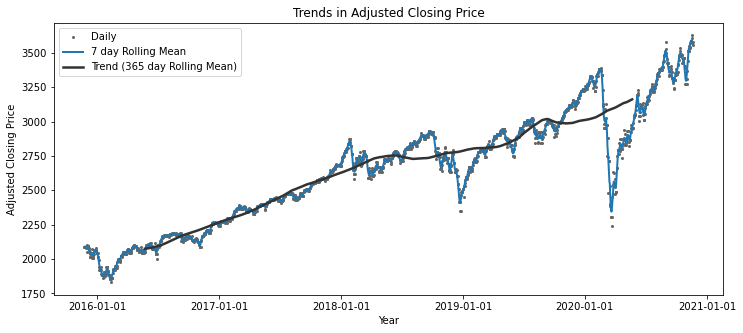

In [114]:
plot_trends_annual_weekly_daily(df, rol_365d, rol_7d, col='Adj Close')

In [115]:
first_order_differencing = calculate_first_order_differencing(df, col='Adj Close')

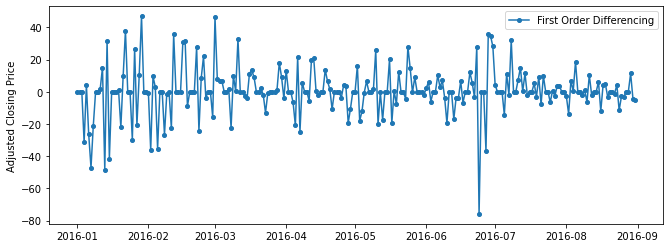

In [116]:
plot_first_order_differencing(first_order_differencing, start = '2016-01', end = '2016-08', col = 'Adj Close')

In [117]:
df = separate_year_month_date(df)

In [118]:
adjusted_closing = feature_engineering(df, col = 'Adj Close')

In [119]:
X_train = adjusted_closing['2015-11-23':'2019-11-23'].drop(['Adj Close'], axis = 1)
y_train = adjusted_closing.loc['2015-11-23':'2019-11-23', 'Adj Close']
X_test = adjusted_closing['2019-11-24':'2020-11-20'].drop(['Adj Close'], axis = 1)
y_test = adjusted_closing.loc['2019-11-24':'2020-11-20', 'Adj Close']

In [120]:
rmse_score = make_scorer(rmse, greater_is_better = False)

In [121]:
best_model = create_decision_tree_regressor(rmse_score, X_train, y_train)

In [122]:
predict_and_regression_results(X_test, y_test)

MSE:  38832.6129
RMSE:  197.0599


# ARIMA Model (calling all functions here)

In [21]:
resampled_data = resample_data_ms(df, col='Adj Close')

In [22]:
pdq, seasonal_pdq = get_seasonal_pdq_combinations()

Some of the parameter combinations for Seasonal ARIMA
SARIMAX: (0, 1, 0) x (0, 0, 1, 12)
SARIMAX: (0, 0, 0) x (0, 1, 0, 12)


In [23]:
get_AIC_score(pdq = pdq, seasonal_pdq = seasonal_pdq, data = resampled_data)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1119.7716431676401
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:853.450244422969
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:695.4555059623424
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:518.5575575899055
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:662.5467128401432
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:644.2401215303266
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:527.8357953601616
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:501.2683465310811
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1025.6709107694528
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:780.5545024134724
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:640.8197210072882
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:478.0255988527385
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:635.4485602300932
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:609.4375156279876
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:504.713168808783
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:470.176415171398
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:727.849961839297
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:589.427130115462
ARIMA(0, 1, 0

In [24]:
results = sarimax_model(order = (1, 1, 1), seasonal_order = (1, 1, 0, 12), data = resampled_data)

In [25]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7127      0.293      2.429      0.015       0.138       1.288
ma.L1         -1.0000      0.117     -8.520      0.000      -1.230      -0.770
ar.S.L12      -0.8054      0.324     -2.487      0.013      -1.440      -0.171
sigma2      1.822e+04   6.44e-06   2.83e+09      0.000    1.82e+04    1.82e+04


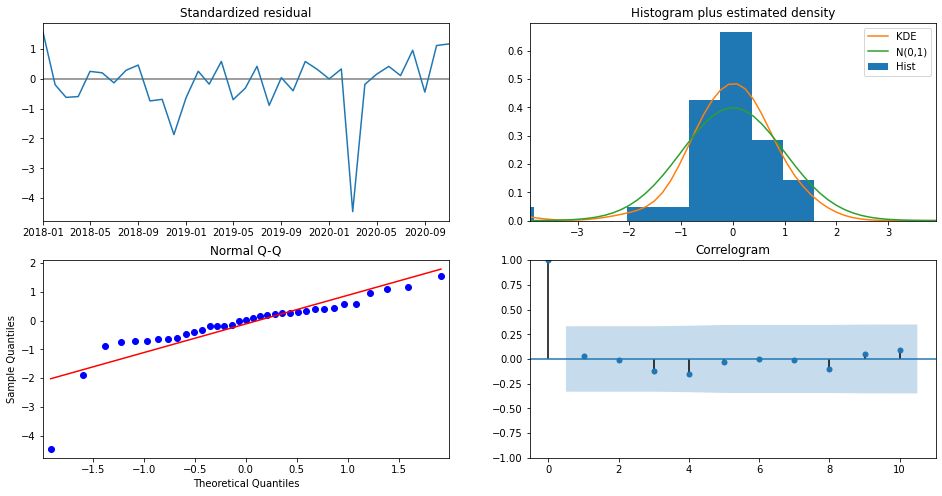

In [26]:
plot_result_diagnostics(results = results)

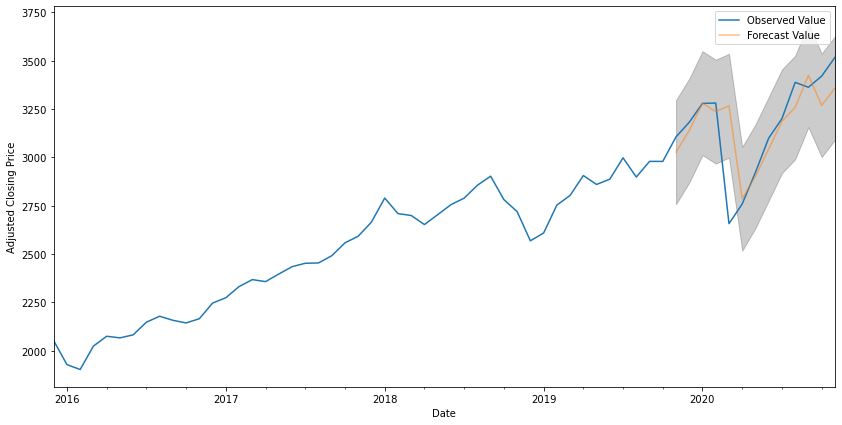

In [27]:
pred = check_prediction_on_existing_data(results = results, date_to_start = '2019-11-01')

In [28]:
mse = get_mean_square_error(pred = pred, test_date_to_start = '2019-11-24')

The Mean Squared Error of our forecasts is 37443.34


In [29]:
get_root_mean_squre_error(mse = mse)

The Root Mean Squared Error of our forecasts is 193.5


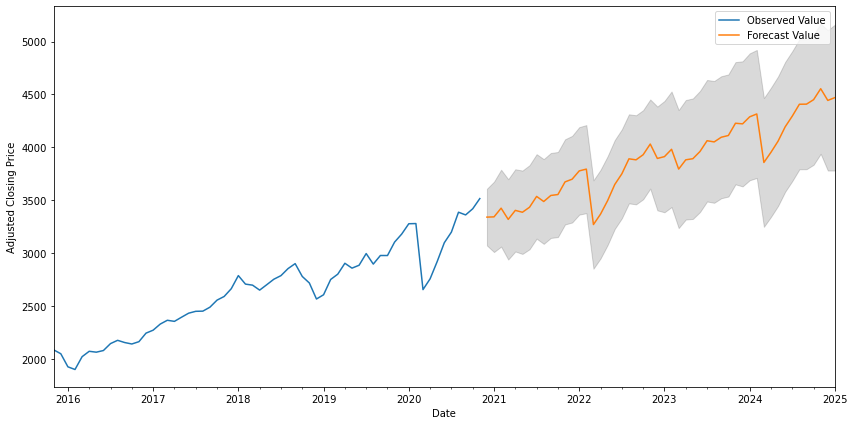

In [30]:
get_future_forecast(results = results, steps = 100, data = resampled_data)